In [11]:
import numpy as np
import galsim
import matplotlib.pyplot as plt
import matplotlib
import batsim

from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

## BATSim IA transform set up (Exaggerated IA)

First we will apply some intrinsic shear to a galaxy.

In [2]:
hlr = 4 # half light radius
scale = 0.2 # arcsec per pixel
nn = 128 # number of pixels per image axis
flux = 40

# we will use a simple sersic galaxy and give it intrinsic ellipticity
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux).shear(e1=0.3)

Next, we will use BATSim to define our stamp and transform objects.

In [71]:
# Create IA transform
IATransform = batsim.IaTransform(
    scale=scale,
    hlr=hlr,
    A=0.2,
    beta=0.92404653,
    phi = np.radians(45),
    clip_radius=5 # clip the transform at n*hlr to prevent edge effects
)

g1,g2 = IATransform.get_g1g2(hlr,0)
print(g1,g2)

lens_sersic = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux).shear(g1=g1, g2=g2)
og_gal = lens_sersic.drawImage(nx=nn, ny=nn, scale=scale, method='auto').array

ia_gal = batsim.simulate_galaxy(
    ngrid=nn,
    pix_scale=scale,
    gal_obj=sersic_gal,
    transform_obj=IATransform,
    psf_obj=None,
    draw_method="auto"
)

6.185722482469045e-18 0.10102051443364382


With these objects, we can then transform the stamp grid and sample the sersic gal onto the transformed grid.
The sampled galaxy is returned as an array of flux values.

Next, let's plot the two galaxies to compare.

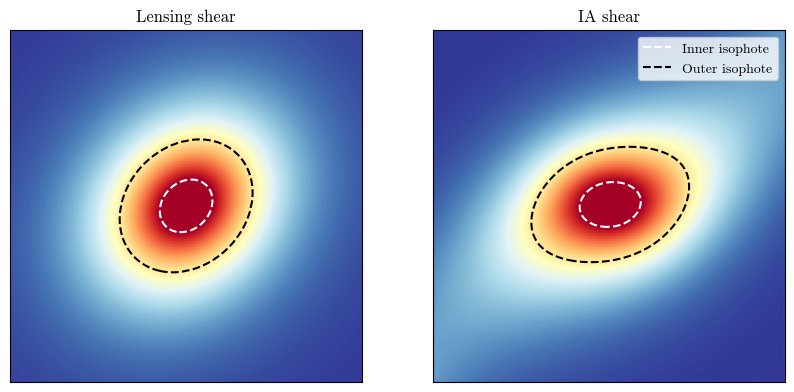

In [87]:
fig, axs = plt.subplots(1,2, figsize=[10,15])

out_cont = np.geomspace(0.005, 0.1, 1)
in_cont = np.geomspace(0.02, 0.6, 1)

norm = simple_norm(ia_gal, "asinh", asinh_a=0.1, min_cut=np.min(ia_gal), max_cut=np.max(ia_gal)/5)

for ax in axs:
    ax.set_xticks([]);
    ax.set_yticks([]);

axs[0].imshow(og_gal, norm=norm, cmap='RdYlBu_r', origin='lower')
axs[0].contour(og_gal, levels=out_cont, colors='black', linestyles='dashed')
axs[0].contour(og_gal, levels=in_cont, colors='white', linestyles='dashed')
axs[0].set_title('Lensing shear')

axs[1].imshow(ia_gal, norm=norm, cmap='RdYlBu_r', origin='lower')
axs[1].contour(ia_gal, levels=out_cont, colors='black', linestyles='dashed')
axs[1].contour(ia_gal, levels=in_cont, colors='white', linestyles='dashed')
axs[1].set_title(r'IA shear')

proxy = [plt.plot([0,0], [1,1],c=c,ls='--') 
    for c in ['white', 'black']]

axs[1].legend(['Inner isophote', 'Outer isophote'], loc='upper right')
plt.savefig('IA_exaggerated_galaxy_compare.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure()
plt.imshow(ia_gal, norm=norm, cmap='RdYlBu_r', origin='lower')
plt.contour(ia_gal, levels=out_cont, colors='black', linestyles='dashed', label='Outer estimator')
plt.contour(ia_gal, levels=in_cont, colors='white', linestyles='dashed', label='Inner estimator')

Clearly, we can see that the alignment gets stronger as we go to outer isophotes of the galaxy. But, this is a very exaggerated level of intrinsic alignment, what would it look like for more realistic values?

## Producing an image with realistic IA

Text(0.5, 1.0, 'Realistic IA at $60^\\circ$')

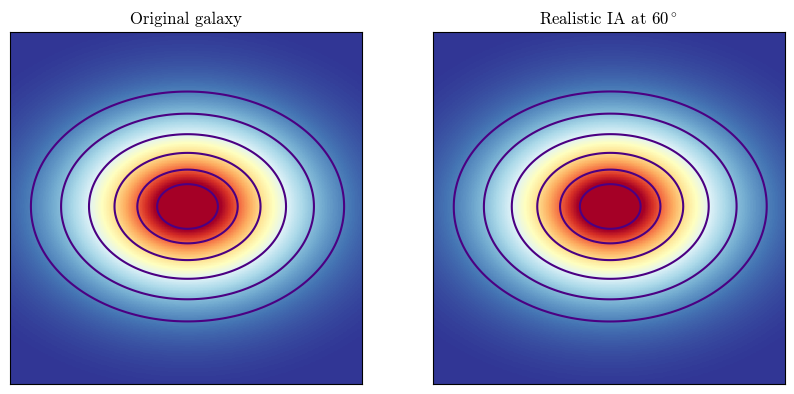

In [9]:
# this is the same code as above, condensed into 1 cell

ia_gal = ia_stamp.sample_galaxy(sersic_gal)
ia_stamp = batstamp.Stamp(nn=nn, scale=scale)
IaTransform = batforms.IaTransform(A=0.001362, beta=0.824, 
                                    phi=np.radians(60), 
                                    hlr=hlr, scale=scale,
                                    clip_radius=5)

ia_stamp.transform_grids(IaTransform)
ia_gal = ia_stamp.sample_galaxy(sersic_gal)

og_min, og_max = batplot.determine_cuts(og_gal)
ia_min, ia_max = batplot.determine_cuts(ia_gal)

og_sn = simple_norm(og_gal, "asinh", asinh_a=0.1, min_cut=og_min, max_cut=og_max)
ia_sn = simple_norm(ia_gal, "asinh", asinh_a=0.1, min_cut=ia_min, max_cut=ia_max)

fig, axs = plt.subplots(1,2, figsize=[10,15])

contours = np.geomspace(0.02, 0.5, 6)

for ax in axs:
    ax.set_xticks([]);
    ax.set_yticks([]);

axs[0].imshow(og_gal, norm=og_sn, cmap='RdYlBu_r', origin='lower')
axs[0].contour(og_gal, levels=contours, colors='indigo')
axs[0].set_title('Original galaxy')

axs[1].imshow(ia_gal, norm=ia_sn, cmap='RdYlBu_r', origin='lower')
axs[1].contour(ia_gal, levels=contours, colors='indigo')
axs[1].set_title(r'Realistic IA at $60^\circ$')
#plt.savefig('IA_realistic_galaxy_compare.png', dpi=300, bbox_inches='tight')

### Residual flux of IA galaxy and original galaxy

Unsurpisingly, its very hard to notice any difference by eye, just like with weak lensing!
However, when we plot the residuals of the two images and normalise again, we can see there is indeed a difference.

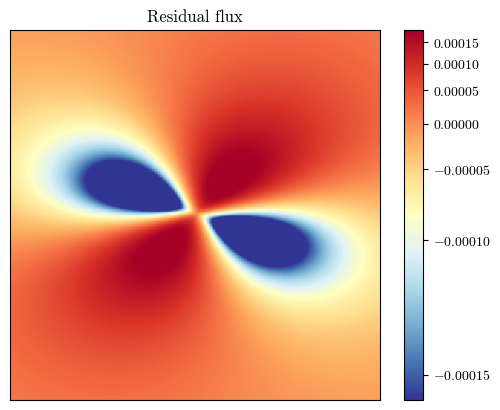

In [10]:
residuals = ia_gal - og_gal
res_min, res_max = batplot.determine_cuts(residuals)
res_sn = simple_norm(residuals, "asinh", asinh_a=0.1, min_cut=res_min, max_cut=res_max)
plt.imshow(residuals, norm=res_sn, cmap='RdYlBu_r', origin='lower')
plt.title('Residual flux')
plt.colorbar()
plt.xticks([]);
plt.yticks([]);
#plt.savefig('IA_residual_flux.png', dpi=300, bbox_inches='tight')

### Comparing to residual flux from a lensing transform

How would these residuals look if our shear had no radial dependence, as seen with typical lensing transforms?

IaTransform has a method which can be used to find the shear at a specific set of coordinates. To compare to lensing, lets find the shear at the half light radius.

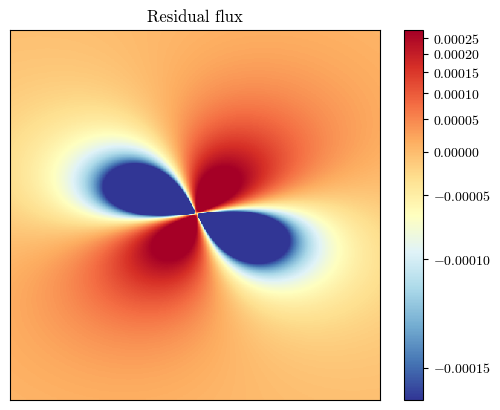

In [11]:
# get the g1 and g2 shear components at hlr
g1, g2 = IaTransform.get_g1g2(hlr,hlr)

# create stamp for lenses galaxy
lens_stamp = batstamp.Stamp(nn=nn, scale=scale)

# we do not include magnification in this case
Lens = batforms.LensTransform(gamma1=g1, gamma2=g2, kappa=0.)
lens_stamp.transform_grids(Lens)
lens_gal = lens_stamp.sample_galaxy(sersic_gal)

residuals = lens_gal - og_gal
res_min, res_max = batplot.determine_cuts(residuals)
res_sn = simple_norm(residuals, "asinh", asinh_a=0.1, min_cut=res_min, max_cut=res_max)
plt.imshow(residuals, norm=res_sn, cmap='RdYlBu_r', origin='lower')
plt.title('Residual flux')
plt.colorbar()
plt.xticks([]);
plt.yticks([]);
#plt.savefig('lensing_residual_flux.png', dpi=300, bbox_inches='tight')

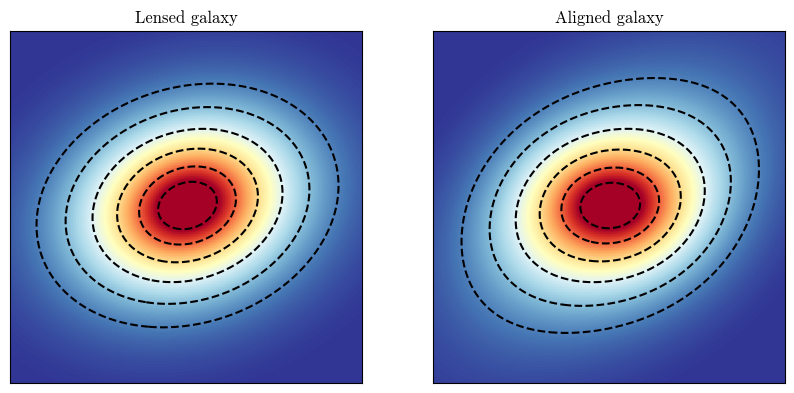

In [12]:
ia_gal = ia_stamp.sample_galaxy(sersic_gal)
ia_stamp = batstamp.Stamp(nn=nn, scale=scale)
IaTransform = batforms.IaTransform(A=0.1362, beta=0.824, 
                                    phi=np.radians(60), 
                                    hlr=hlr, scale=scale,
                                    clip_radius=5)

ia_stamp.transform_grids(IaTransform)
ia_gal = ia_stamp.sample_galaxy(sersic_gal)

# get the g1 and g2 shear components at hlr
g1, g2 = IaTransform.get_g1g2(hlr,hlr)

# create stamp for lenses galaxy
lens_stamp = batstamp.Stamp(nn=nn, scale=scale)

# we do not include magnification in this case
Lens = batforms.LensTransform(gamma1=g1, gamma2=g2, kappa=0.)
lens_stamp.transform_grids(Lens)
lens_gal = lens_stamp.sample_galaxy(sersic_gal)

fig, axs = plt.subplots(1,2, figsize=[10,15])

contours = np.geomspace(0.02, 0.5, 6)

for ax in axs:
    ax.set_xticks([]);
    ax.set_yticks([]);

axs[0].imshow(lens_gal, norm=og_sn, cmap='RdYlBu_r', origin='lower')
axs[0].contour(lens_gal, levels=contours, colors='k',linestyles='dashed')
axs[0].set_title('Lensed galaxy')

axs[1].imshow(ia_gal, norm=ia_sn, cmap='RdYlBu_r', origin='lower')
axs[1].contour(ia_gal, levels=contours, colors='k', linestyles='dashed')
axs[1].set_title(r'Aligned galaxy')
plt.savefig('IA_exaggerated_galaxy_compare.pdf', dpi=300, bbox_inches='tight')